In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.conv3 = nn.Conv2d(32, 64, 5, 1, 2)
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [3]:
def visualize_filters(layer, layer_name):
    filters = layer.weight.data.cpu().numpy()
    n_filters = filters.shape[0]

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.suptitle(f'Filters from {layer_name}', fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < min(16, n_filters):
            if filters.shape[1] == 1:
                ax.imshow(filters[i, 0, :, :], cmap='gray')
            else:
                filter_rgb = np.transpose(filters[i, :3, :, :], (1, 2, 0))
                filter_rgb = (filter_rgb - filter_rgb.min()) / (filter_rgb.max() - filter_rgb.min())
                ax.imshow(filter_rgb)
            ax.set_title(f'Filter {i}')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
def visualize_feature_maps(feature_maps, layer_name):
    feature_maps = feature_maps.cpu().detach().numpy()
    n_maps = feature_maps.shape[1]

    if n_maps >= 16:
        rows, cols = 4, 4
        maps_to_show = 16
    else:
        rows = int(np.sqrt(n_maps))
        cols = int(np.ceil(n_maps / rows))
        maps_to_show = n_maps

    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    fig.suptitle(f'Feature Maps from {layer_name}', fontsize=16)

    if rows == 1:
        axes = axes.reshape(1, -1)
    if cols == 1:
        axes = axes.reshape(-1, 1)

    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < maps_to_show:
                axes[i, j].imshow(feature_maps[0, idx, :, :], cmap='viridis')
                axes[i, j].set_title(f'Map {idx}')
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
def get_feature_maps(model, x):
    feature_maps = {}
    x = x

    x = F.relu(model.conv1(x))
    feature_maps['conv1'] = x.clone()
    x = model.pool(x)

    x = F.relu(model.conv2(x))
    feature_maps['conv2'] = x.clone()
    x = model.pool(x)

    x = F.relu(model.conv3(x))
    feature_maps['conv3'] = x.clone()
    x = model.pool(x)

    return feature_maps


In [6]:
def show_original_images(images, labels):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle('Original MNIST Images', fontsize=16)

    for i in range(8):
        row = i // 4
        col = i % 4
        img = images[i].squeeze().numpy()
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(f'Label: {labels[i].item()}')
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [8]:
trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

trainloader = DataLoader(trainset, batch_size=8, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.12MB/s]


In [9]:
model = CNN()

dataiter = iter(trainloader)
images, labels = next(dataiter)

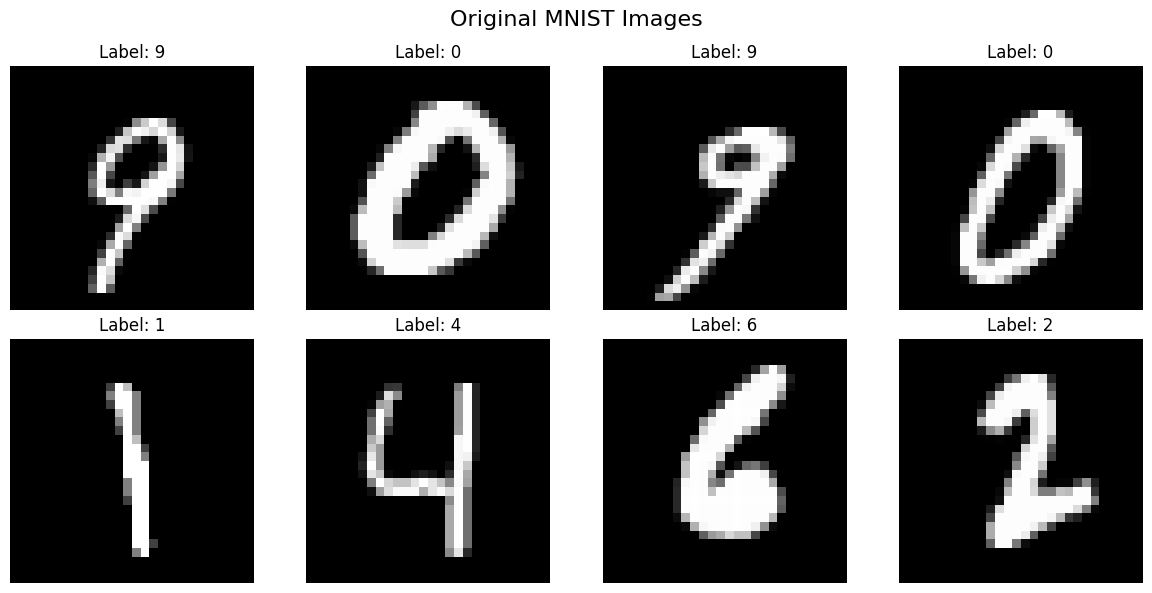

In [10]:
show_original_images(images, labels)

Visualizing Filters from Each Layer:


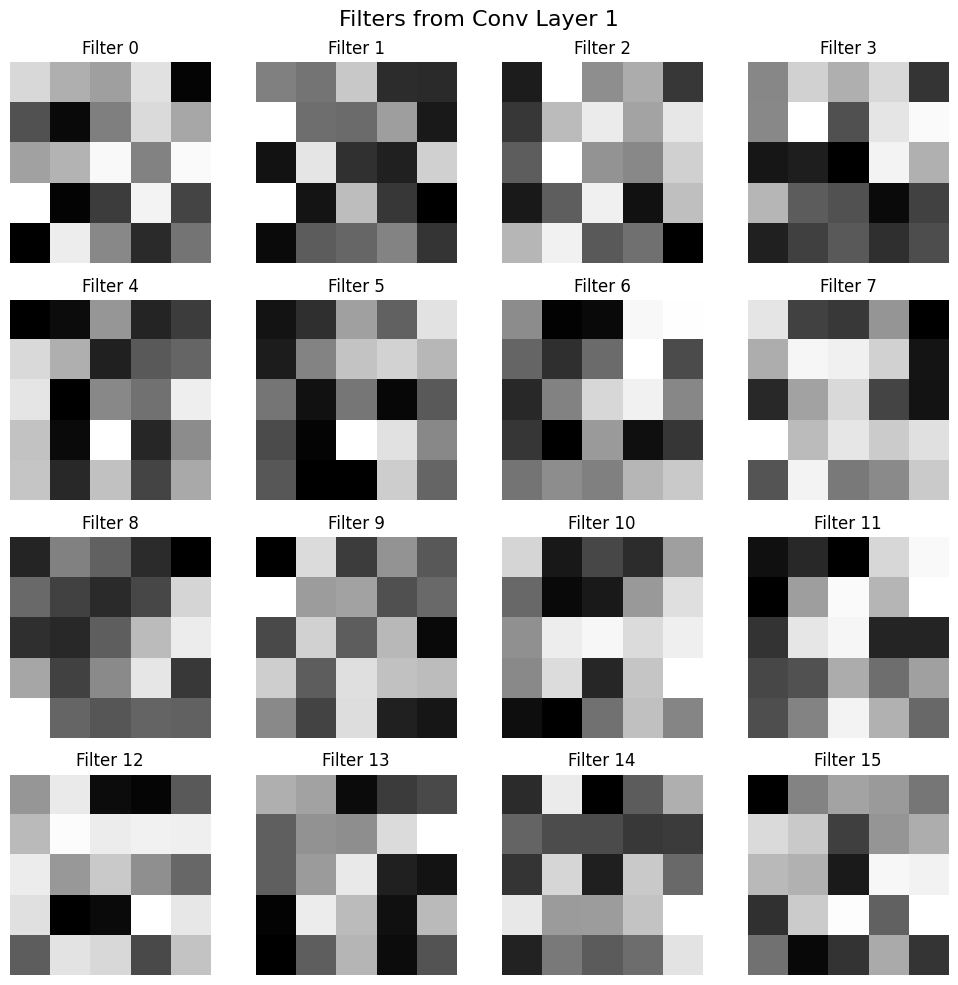

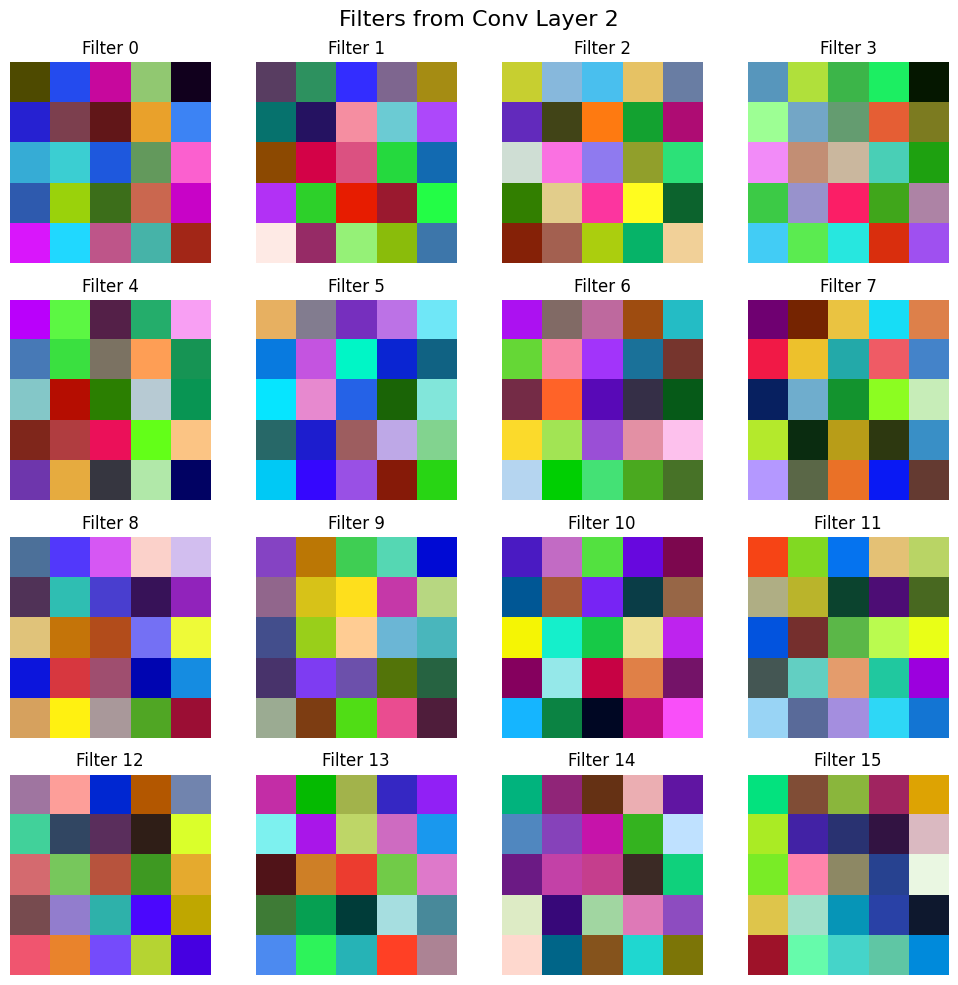

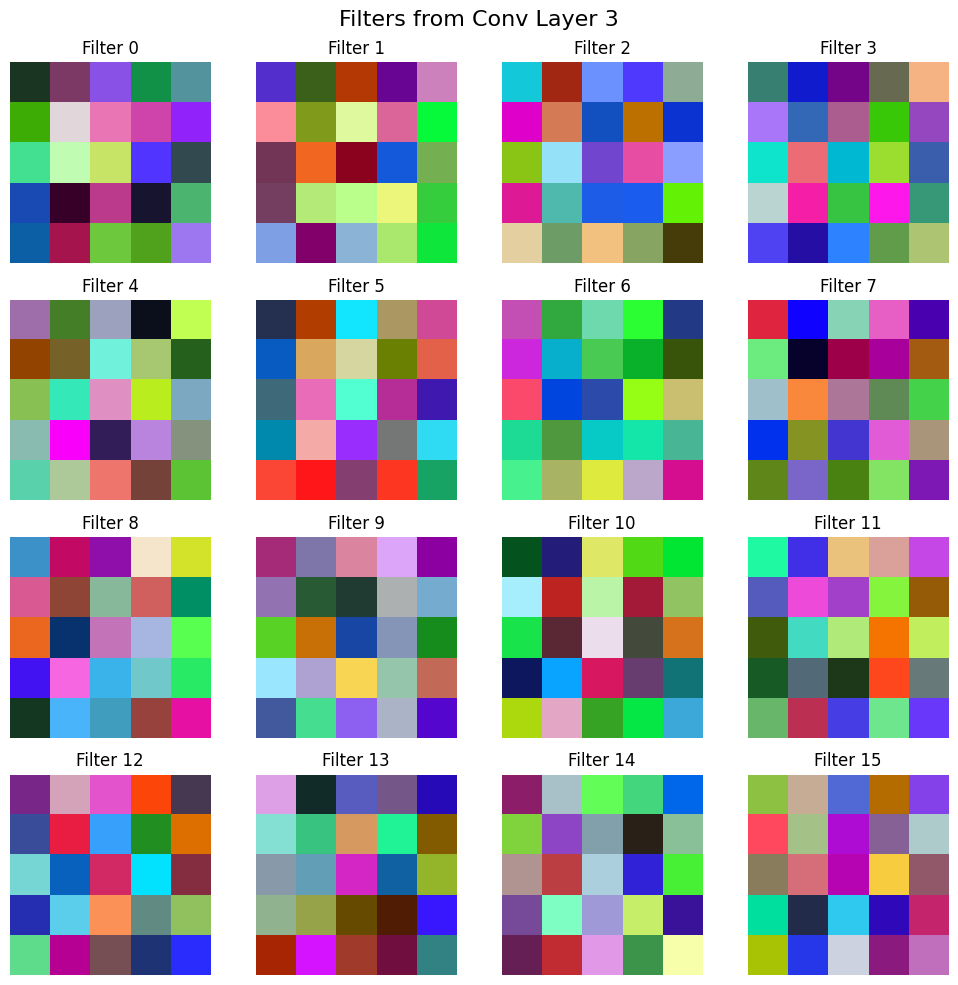

In [11]:
print("Visualizing Filters from Each Layer:")
visualize_filters(model.conv1, "Conv Layer 1")
visualize_filters(model.conv2, "Conv Layer 2")
visualize_filters(model.conv3, "Conv Layer 3")

In [12]:
feature_maps = get_feature_maps(model, images)

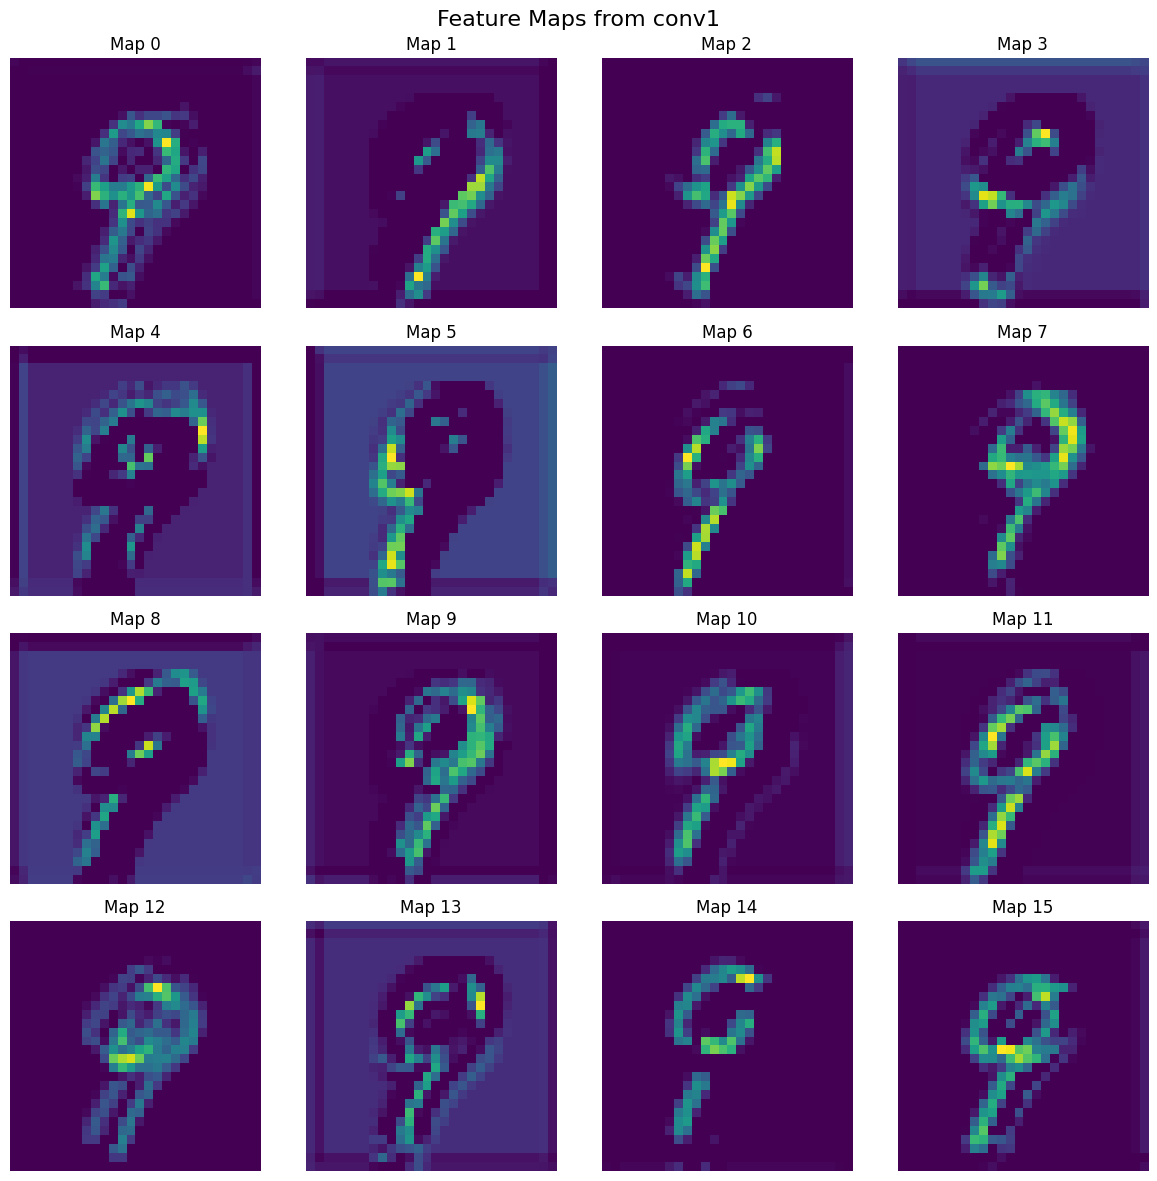

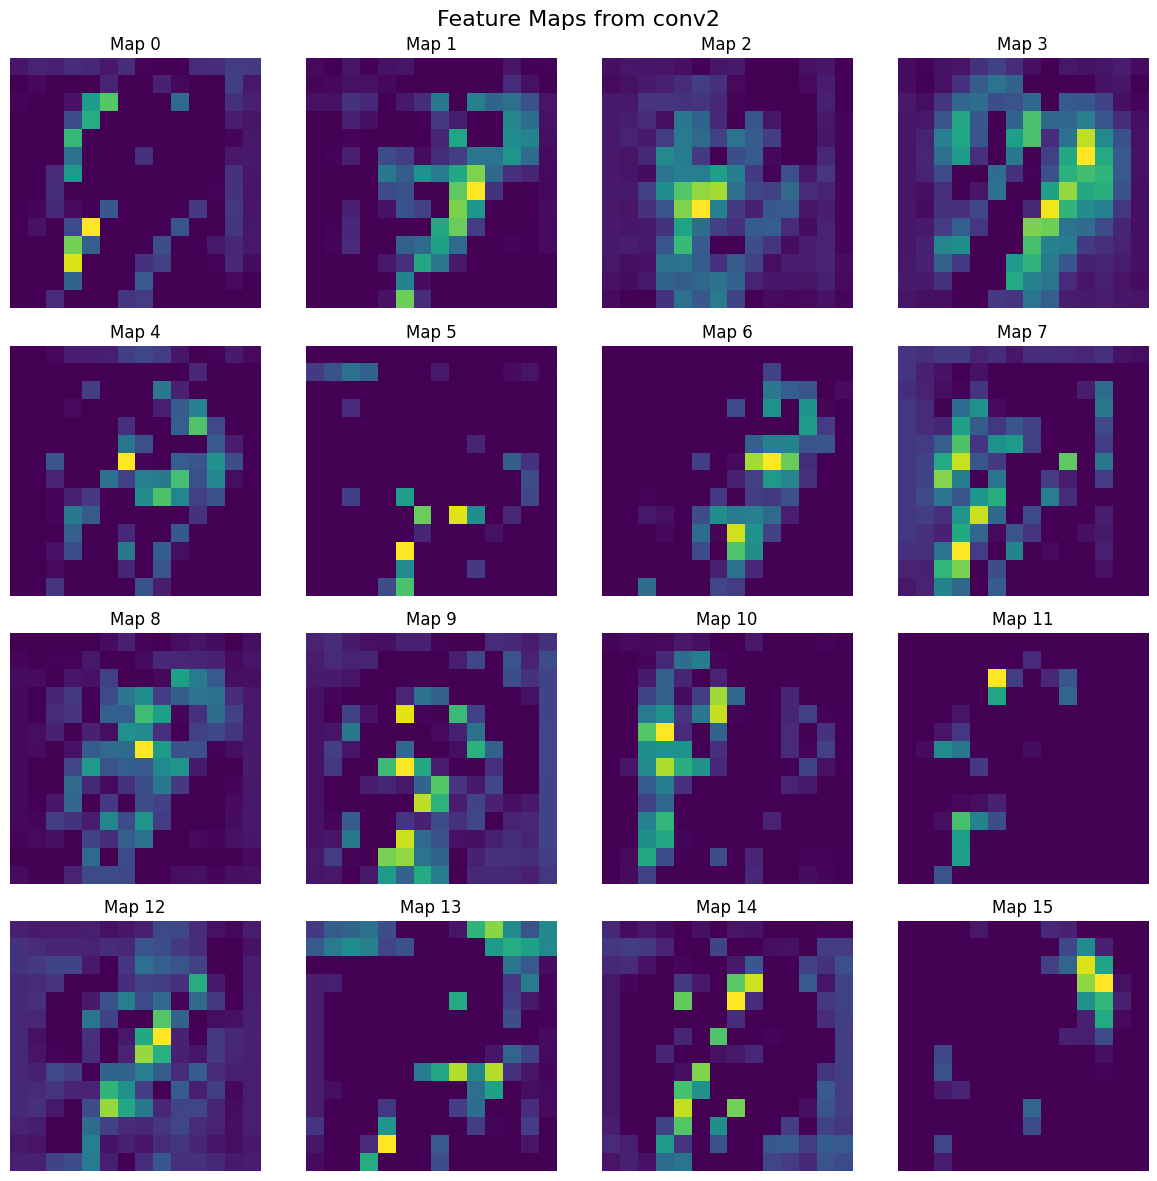

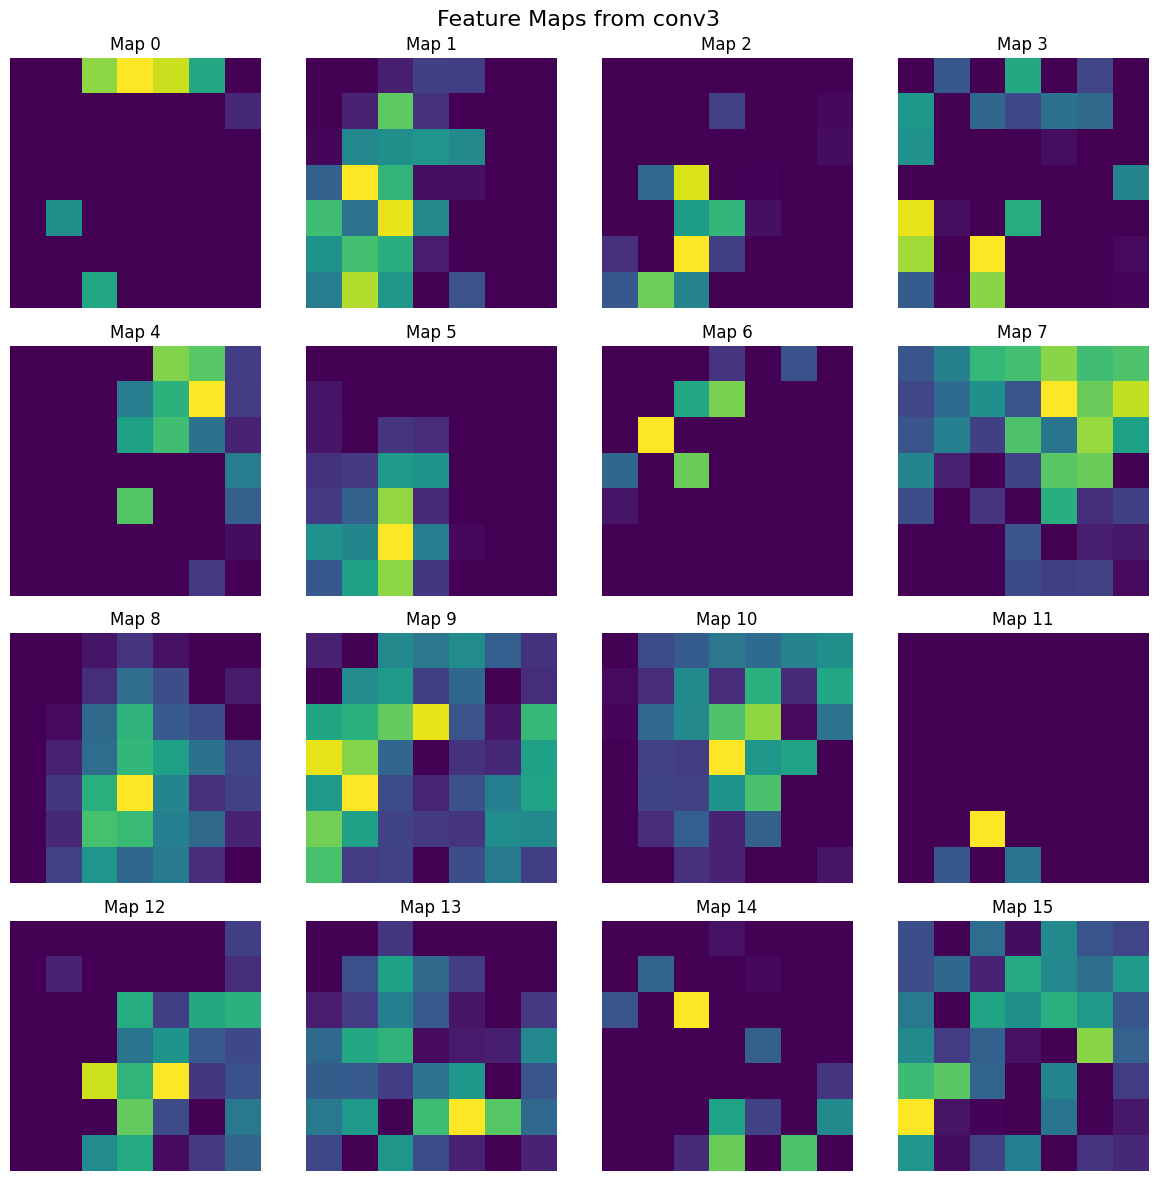

In [13]:
for layer_name, fmaps in feature_maps.items():
    visualize_feature_maps(fmaps, layer_name)

In [14]:

sample_image = images[0:1]
with torch.no_grad():
    conv1_output = F.relu(model.conv1(sample_image))
    pooled1 = model.pool(conv1_output)

    conv2_output = F.relu(model.conv2(pooled1))
    pooled2 = model.pool(conv2_output)

    conv3_output = F.relu(model.conv3(pooled2))
    pooled3 = model.pool(conv3_output)

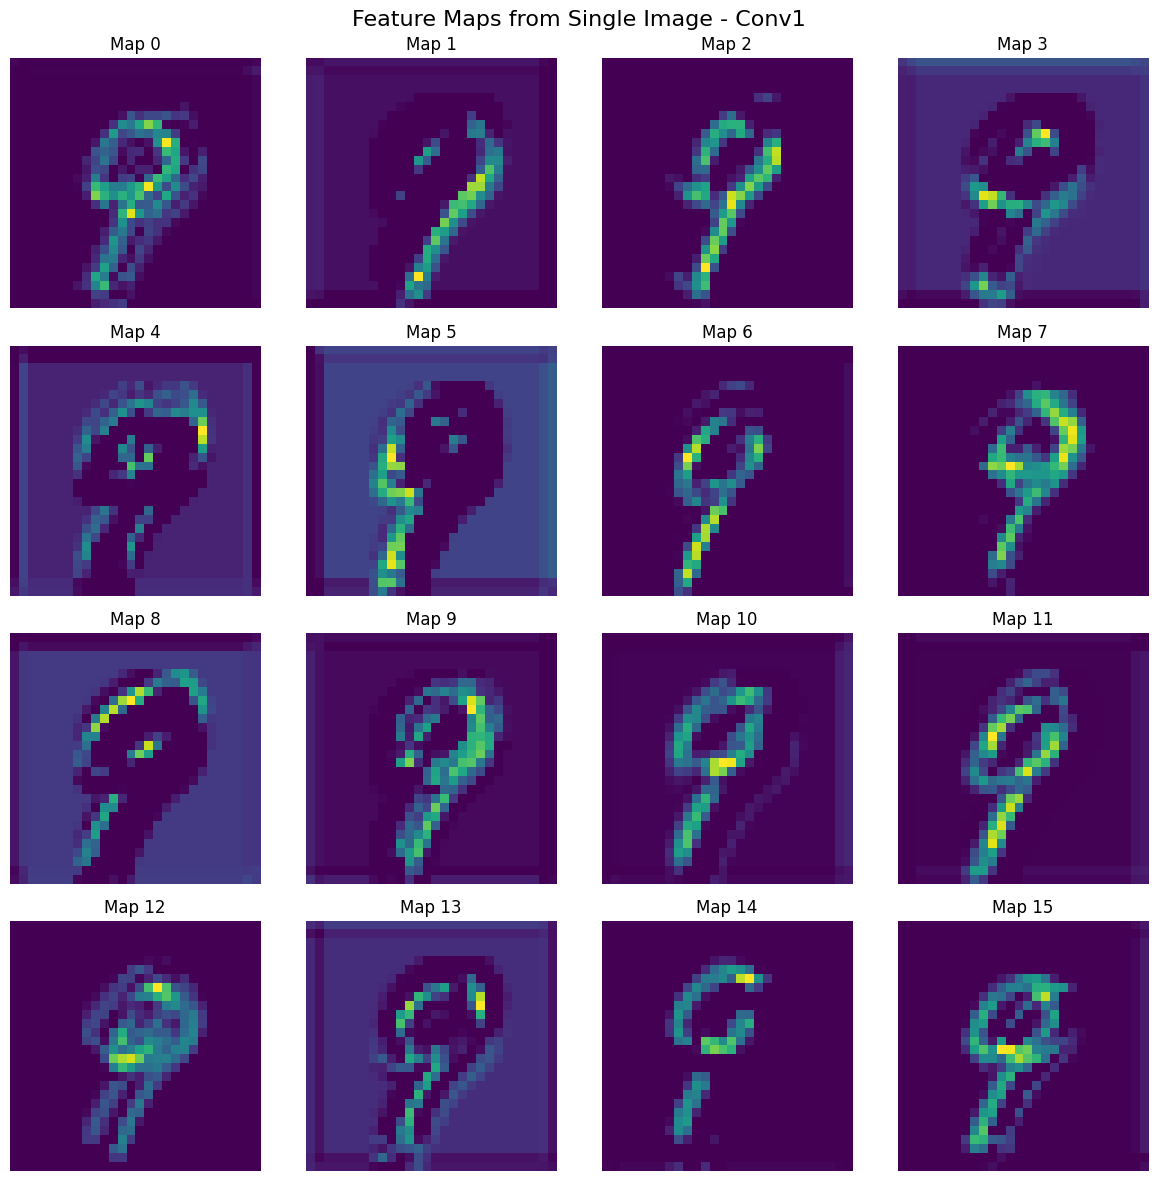

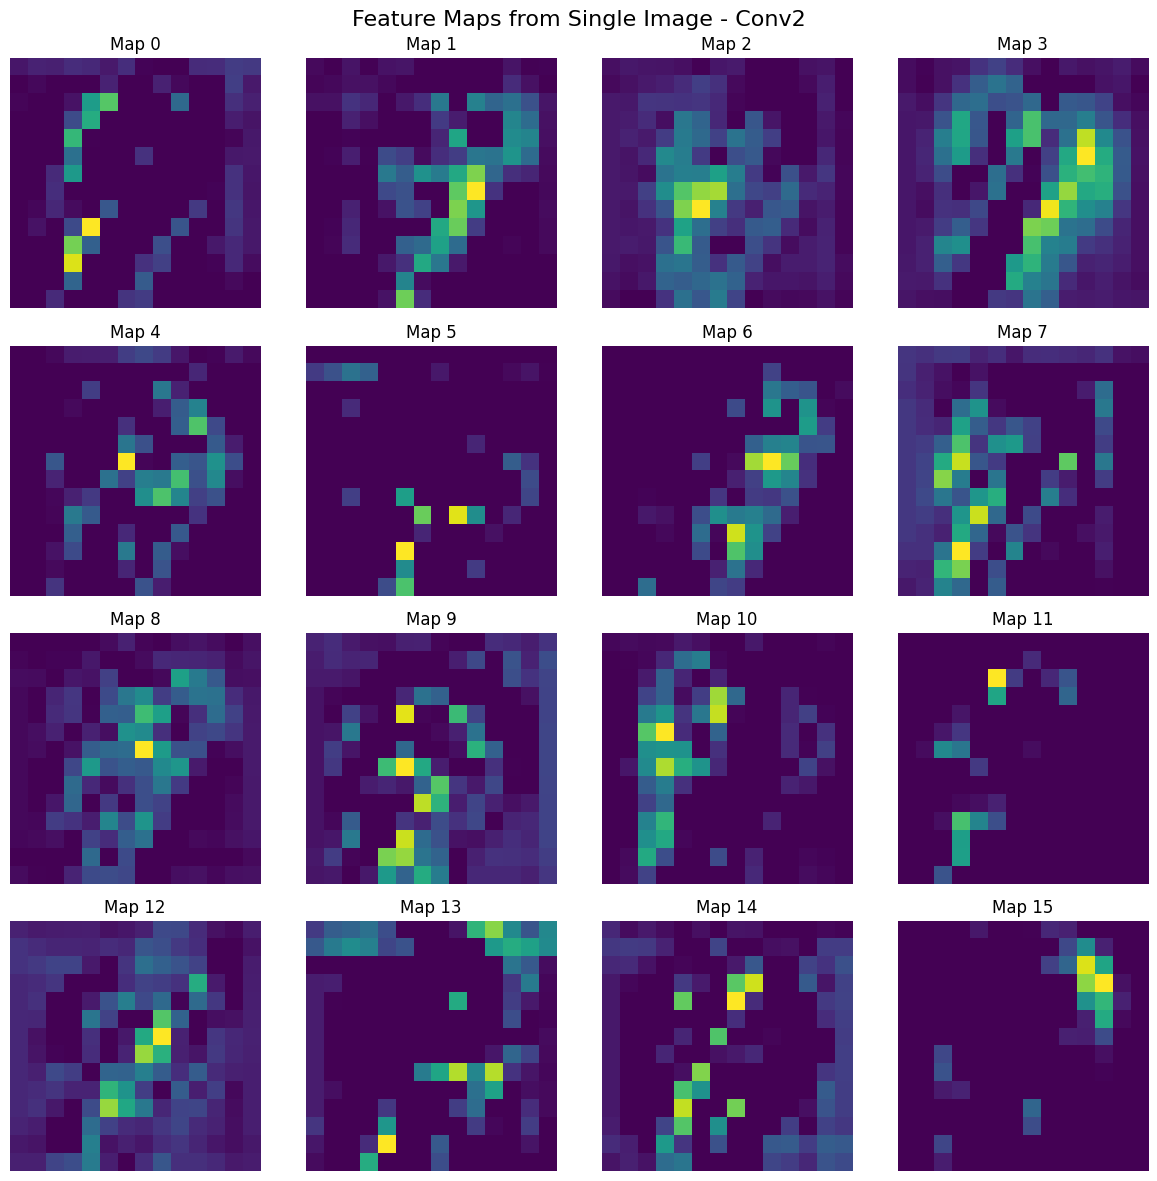

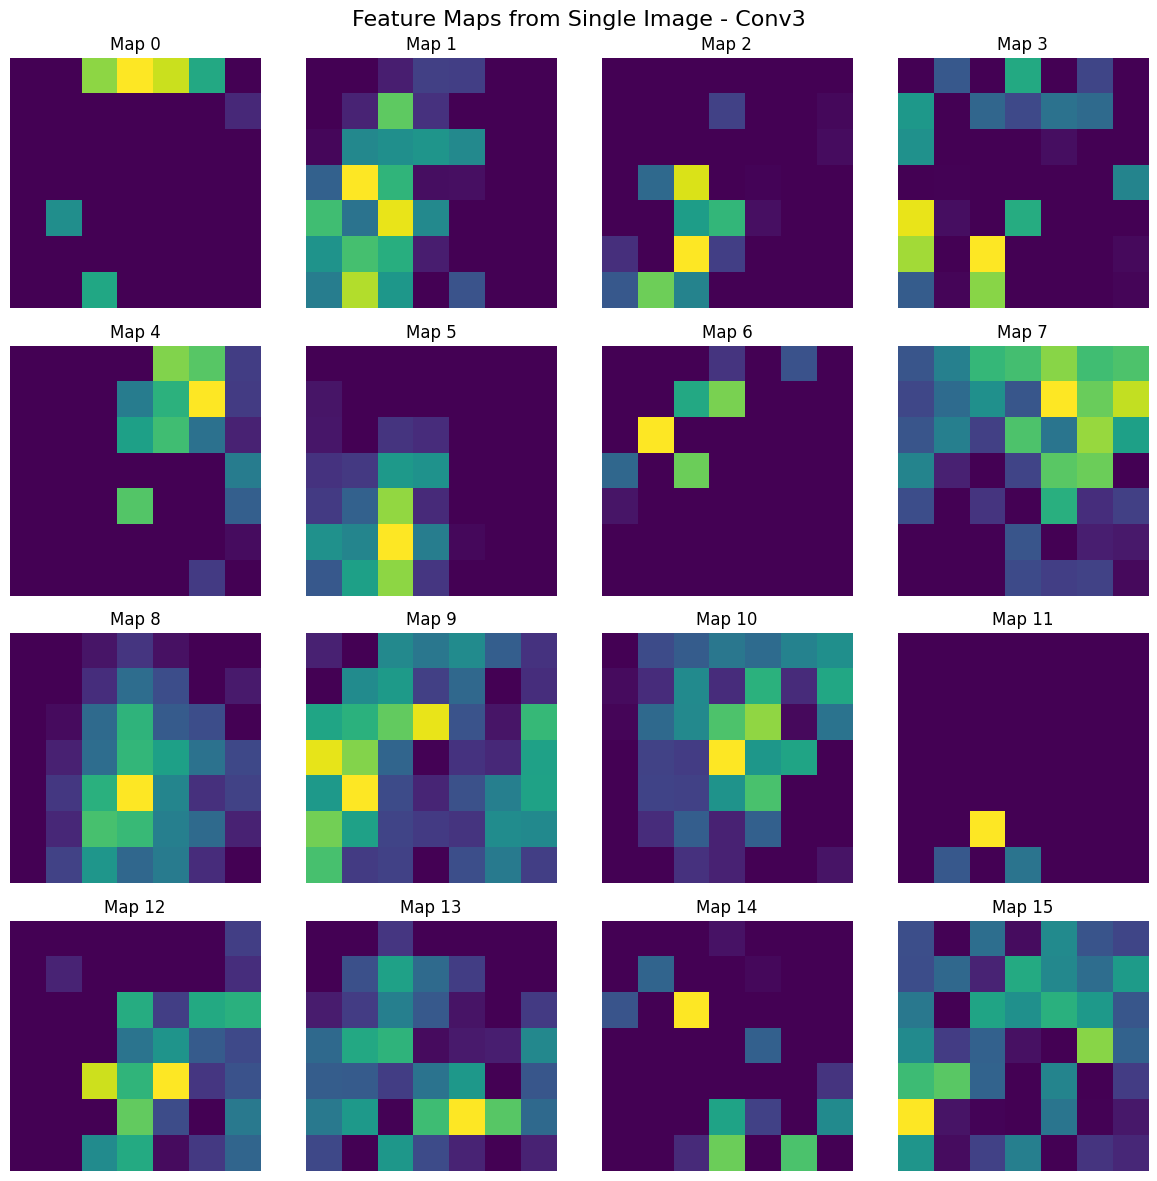

In [15]:
visualize_feature_maps(conv1_output, "Single Image - Conv1")
visualize_feature_maps(conv2_output, "Single Image - Conv2")
visualize_feature_maps(conv3_output, "Single Image - Conv3")

In [16]:
filter_weights_conv1 = model.conv1.weight.data
filter_weights_conv2 = model.conv2.weight.data
filter_weights_conv3 = model.conv3.weight.data

print(f"Conv1 filters shape: {filter_weights_conv1.shape}")
print(f"Conv2 filters shape: {filter_weights_conv2.shape}")
print(f"Conv3 filters shape: {filter_weights_conv3.shape}")


Conv1 filters shape: torch.Size([16, 1, 5, 5])
Conv2 filters shape: torch.Size([32, 16, 5, 5])
Conv3 filters shape: torch.Size([64, 32, 5, 5])


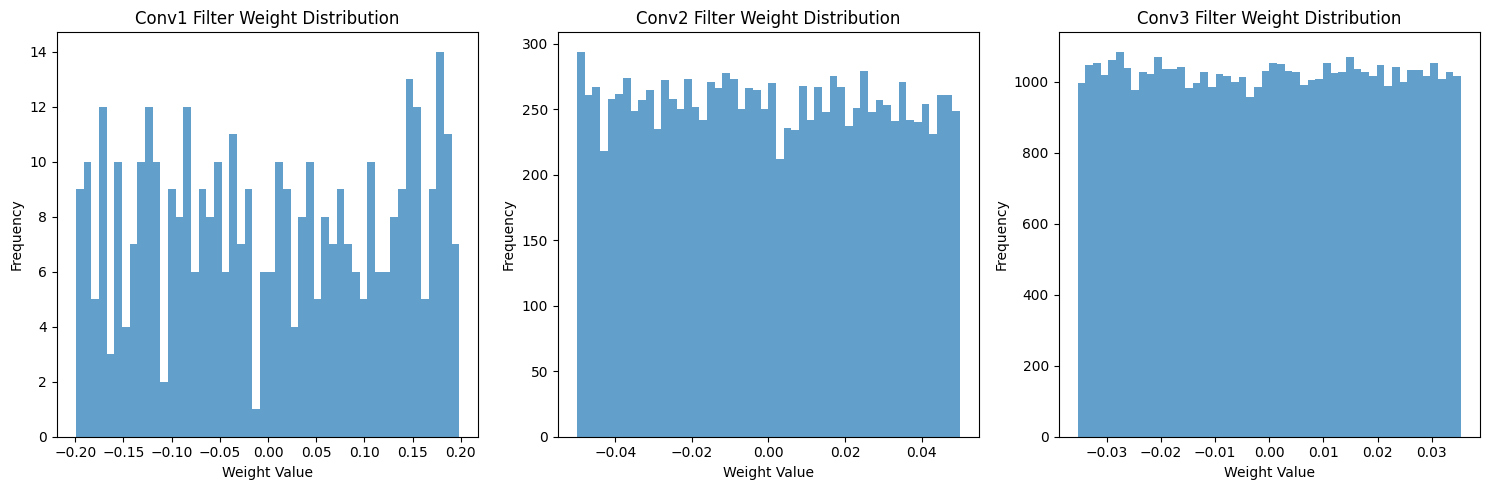

In [17]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(filter_weights_conv1.numpy().flatten(), bins=50, alpha=0.7)
plt.title('Conv1 Filter Weight Distribution')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(filter_weights_conv2.numpy().flatten(), bins=50, alpha=0.7)
plt.title('Conv2 Filter Weight Distribution')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(filter_weights_conv3.numpy().flatten(), bins=50, alpha=0.7)
plt.title('Conv3 Filter Weight Distribution')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()